# `CLOUD.jl` - 1D linear advection with dynamic mode decomposition

In [19]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
plots_path = "../plots/advection_dgmulti_1D_linear_test/"
results_path = "../results/advection_dgmulti_1D_linear_test/";

Define the physical problem

In [20]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 8*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a quadrature-based DG scheme of degree `p` with `M` elements and periodic boundary conditions

In [21]:
M = 6  # number of elements
p = 4  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGMulti(p), Line(), N_plot=20)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [22]:
n_s = prod(get_dof(spatial_discretization,conservation_law))
dt_scale=0.005
dt = dt_scale*(L/M)/(a*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, floor(Int, T/(dt*(n_s-1)))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

Visualize the solution

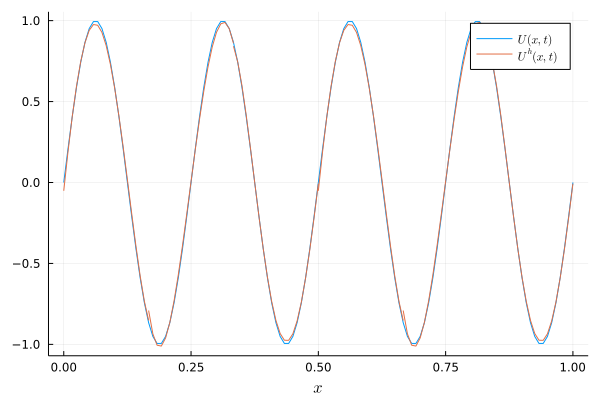

In [23]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [24]:
error_analysis = ErrorAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("L2 error: ", analyze(error_analysis, last(sol.u), initial_data))

conservation_analysis = PrimaryConservationAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)

energy_analysis = EnergyConservationAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error: [0.013492579153604266]
Conservation (initial/final/diff):
[1.249000902703301e-16][5.759281940243e-16][4.510281037539698e-16]
Energy (initial/final/diff):
[0.5000000000000004][0.4879251851232899][-0.012074814876710527]


Perform a DMD and compare to linear eigenanalysis

In [25]:
r=n_s-2
tol = 1.0e-12
dmd_analysis = DMDAnalysis(results_path, r=r, tol=1.0e-12)
linear_analysis = LinearAnalysis(results_path, dt=dmd_analysis.dt, r=r, tol=1.0e-12, X=dmd_analysis.X)
dmd_results = analyze(dmd_analysis)
linear_results = analyze(linear_analysis);

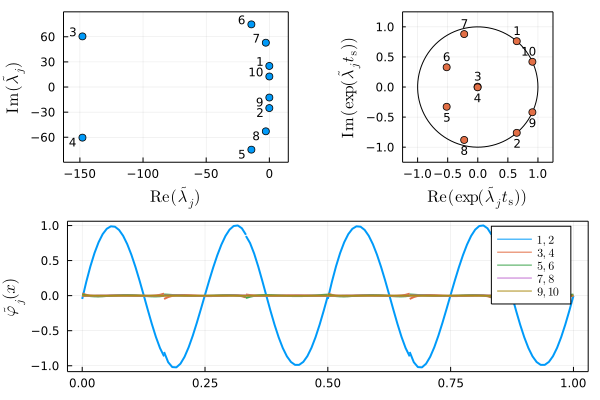

In [26]:
plot_analysis(dmd_analysis, dmd_results)

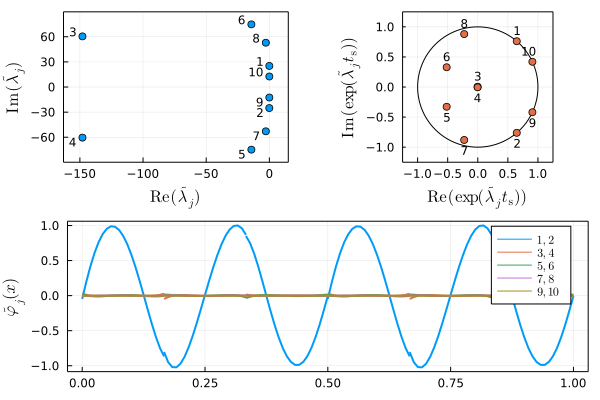

In [27]:
plot_analysis(linear_analysis, linear_results)